# Simpsons Classifier


## Images with different sizes: understanding _Spatial Pyramid Pooling_

If the neural network has a fixed size as input images we'll have to deal with it. 

So the possible solutions will be:

* Crop: problem, there is information that gets lost.
* Warp/Resize: problem, the image patterns change and we lose accuracy.
* Padding: problem, the model might be biased to images that contain such a padded border.
* Combination of previous.

Spatial Pyramid Pooling tries to resolve it. Indeed it should improve the efficiency.

Paper: https://arxiv.org/abs/1406.4729

## Defining Datasets

In [27]:
#Import libraries
import os
import glob
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.misc import imread, imresize
from random import shuffle
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [2]:
#Initial data inside simpsons.tar.gz
info = pd.read_csv('./the-simpsons-characters-dataset-MEDIUM/number_pic_char.csv')
print(info)

    Unnamed: 0                      name  total  train  test  bounding_box
0            0             Homer Simpson   2246   1909   337           612
1            1              Ned Flanders   1454   1236   218           595
2            2               Moe Szyslak   1452   1234   218           215
3            3              Lisa Simpson   1354   1151   203           562
4            4              Bart Simpson   1342   1141   201           554
5            5             Marge Simpson   1291   1097   194           557
6            6          Krusty The Clown   1206   1025   181           226
7            7         Principal Skinner   1194   1015   179           506
8            8  Charles Montgomery Burns   1193   1014   179           650
9            9       Milhouse Van Houten   1079    917   162           210
10          10              Chief Wiggum    986    838   148           209
11          11    Abraham Grampa Simpson    913    776   137           595
12          12           

In [3]:
def get_character_directories(path):
    character_directories = os.listdir(path)
    if '.DS_Store' in character_directories: character_directories.remove('.DS_Store')
    return character_directories

def get_images_from_directory(path):
    image_files = os.listdir(path)
    if '.DS_Store' in image_files: image_files.remove('.DS_Store')
    return image_files

In [4]:
#root pats
train_root_path = "./the-simpsons-characters-dataset-MEDIUM/simpsons_dataset"
test_root_path = "./the-simpsons-characters-dataset-MEDIUM/kaggle_simpson_testset"

#train directories
character_directories = get_character_directories(train_root_path)

In [5]:
def test_paths():
    #configure train dataset
    print("Train: {}".format(character_directories[:5]))

    #images from one train directory
    character_path = train_root_path + "/" + character_directories[1]
    train_image_names = get_images_from_directory(character_path)
    print("Images of {}: {}".format(character_directories[1], train_image_names[:5]))


    #configure test dataset
    test_image_names = get_images_from_directory(test_root_path)
    print("\nTest: {}".format(test_image_names[:5]))

test_paths()

Train: ['maggie_simpson', 'charles_montgomery_burns', 'patty_bouvier', 'ralph_wiggum', 'chief_wiggum']
Images of charles_montgomery_burns: ['pic_0982.jpg', 'pic_0028.jpg', 'pic_0996.jpg', 'pic_0766.jpg', 'pic_0000.jpg']

Test: ['principal_skinner_34.jpg', 'apu_nahasapeemapetilon_28.jpg', 'abraham_grampa_simpson_41.jpg', 'principal_skinner_20.jpg', 'apu_nahasapeemapetilon_14.jpg']


### Showing Training and Test Samples

In [6]:
def plot_image(image):
    plt.figure(figsize=(3, 3))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

Label:milhouse_van_houten, Image:6, Shape:(108, 72, 3)


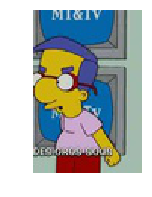

In [7]:
def show_train_image(character_directory, idx):
    directory = os.path.join(train_root_path, character_directory)
    sample_file = get_images_from_directory(directory)[idx]
    path_file = os.path.join(directory, sample_file)
    sample_image = imread(path_file)

    print("Label:{}, Image:{}, Shape:{}".format(character_directory, idx, sample_image.shape))
    plot_image(sample_image)
    
idx = random.randint(0, 10)
show_train_image(character_directories[idx], idx)

Label:apu_nahasapeemapetilon, Image:1, Shape:(86, 57, 3)


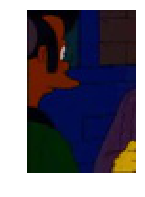

In [8]:
def show_test_image(idx):
    test_image_names = get_images_from_directory(test_root_path)
    sample_file, sample_name = test_image_names[idx], test_image_names[idx].split('_')[:-1]
    path_file = os.path.join(test_root_path, sample_file)
    sample_image = imread(path_file)

    print("Label:{}, Image:{}, Shape:{}".format('_'.join(sample_name), idx, sample_image.shape))
    plot_image(sample_image)

idx = random.randint(0, 10)
show_test_image(idx)

### Training Images

In [9]:
'''
Input 'different_characters' will define the number of different Simpson
characters the generator is going to return

@Return: tuple (images list, names list)
'''
#Create the batch generator
def batch_generator_training_images(batch_size, different_characters, verbose=False):
    #Obtain the characters Serie with the most number of images
    characters = info.sort_values(by='total', ascending=False).name

    #transform to list with the following format:  Homer Simpson -> homer_simpson
    characters = characters.map(lambda x: x.replace(" ", "_").lower()).tolist()

    path_name_list = list()
    for i in range(0, different_characters):
        directory = os.path.join(train_root_path, characters[i])
        path_name_list += list(map( lambda x: (os.path.join(directory, x), characters[i]), 
                                    get_images_from_directory(directory)))

    #shuffle all the images
    shuffle(path_name_list)
    
    #getting a number of complete chunks according to the batch size
    number_complete_chunks = len(path_name_list)//batch_size
    num_images_in_all_chunks = number_complete_chunks * batch_size
        
    for b in range(0, num_images_in_all_chunks, batch_size):
        if verbose:
            print("init: {}, end:{}".format(b, b+batch_size))
        
        yield (list(map( lambda x: imread(x[0]), path_name_list[b:b + batch_size])), #x == path
               list(map( lambda x: x[1], path_name_list[b:b + batch_size])) ) #x == name


init: 0, end:32
marge_simpson


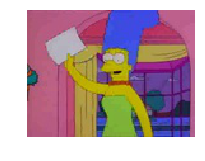

In [10]:
#testing how to show an image from generator
def testing_generator_1():
    for batch in batch_generator_training_images(32, 10, True):
        for img, name in zip(*batch):
            print(name)
            plot_image(img)
            break
        pass
        break
        
testing_generator_1()

In [11]:
#testing the generator
def testing_generator_2():
    group = {}

    for batch in batch_generator_training_images(8, 10, True):
        for img, name in zip(*batch):
            if not img.shape in group:
                group[img.shape] = []
            group[img.shape].append(img)
        pass
        break

    for key, lists in group.items():
        print("shape{} count:{}".format(key, len(lists)))


testing_generator_2()

init: 0, end:8
shape(108, 72, 3) count:3
shape(88, 78, 3) count:1
shape(104, 144, 3) count:1
shape(120, 160, 3) count:1
shape(100, 66, 3) count:1
shape(104, 72, 3) count:1


In [12]:
#global variable
num_classes = 10 #different number of Simpons characters

In [13]:
#one hot encoder
lb = preprocessing.LabelBinarizer()

def customize_onehot_encoder(num_classes):
    #Obtain the characters Serie with the most number of images
    characters = info.sort_values(by='total', ascending=False).name

    #transform to list with the following format:  Homer Simpson -> homer_simpson
    names = characters[:num_classes].map(lambda x: x.replace(" ", "_").lower()).tolist()

    print("Character classes: {}\n".format(names))
    lb.fit(names)


### Storing Processed Files On Disk

In [14]:
#global variable
file_prefix = "spp_simpson_train_"
batch_size = 1024

In [20]:
import pickle

def create_processed_files(batch_size=64):
    customize_onehot_encoder(num_classes)
    # Format of data => {shape: {'images':[], 'labels':[]} }
    data = {}
    
    '''
    The batch generator returns a tuple of two lists!!! (list_images, list_names)
    '''
    for cnt, batch in enumerate(batch_generator_training_images(batch_size, num_classes)):
                
        #group by shape
        grouped = {}
        for image, name in zip(*batch):
            if not image.shape in grouped:
                grouped[image.shape] = []
            grouped[image.shape].append((image, name))        
        
        #training images which are grouped by shape at the same time
        for shape, tuple_imagesList_namesList in grouped.items():
            imagesList, namesList = zip(*tuple_imagesList_namesList)
            
            #casting
            images = np.array(imagesList)
            #onehot encoding names
            names = np.array(lb.transform(namesList))
            
            if len(shape) == 3: #just in case dimension are less than 3
                #print("Storing shape:{} with {}".format(shape, len(images)))
                data[shape] = {'images': images, 'labels': names}
            else:
                print("W: Dim image < 3")
        
        #save into disk
        with open("{}{}.pkl".format(file_prefix, cnt), 'wb') as file:
            pickle.dump(data, file, pickle.HIGHEST_PROTOCOL)
            print("{} saved".format("{}{}.pkl".format(file_prefix, cnt)))
        

create_processed_files(batch_size)

Character classes: ['homer_simpson', 'ned_flanders', 'moe_szyslak', 'lisa_simpson', 'bart_simpson', 'marge_simpson', 'krusty_the_clown', 'principal_skinner', 'charles_montgomery_burns', 'milhouse_van_houten']

spp_simpson_train_0.pkl saved
spp_simpson_train_1.pkl saved
spp_simpson_train_2.pkl saved
spp_simpson_train_3.pkl saved
spp_simpson_train_4.pkl saved
spp_simpson_train_5.pkl saved
W: Dim image < 3
spp_simpson_train_6.pkl saved
spp_simpson_train_7.pkl saved
spp_simpson_train_8.pkl saved
spp_simpson_train_9.pkl saved
spp_simpson_train_10.pkl saved
spp_simpson_train_11.pkl saved
spp_simpson_train_12.pkl saved


Since here, the images are processed and stored in different pickle files. 

The format of the __data is a dictionary__ which follows the format:  
```
{shape: {'images':[], 'labels':[]} }
```

## Keras + SPP Module

Keras doesn't support currently the SSP layer but thanks to [yhenon](https://github.com/yhenon) there's a module which is integrated into keras. [Code is here](https://github.com/yhenon/keras-spp)

In [21]:
from keras.models import Sequential
from keras.layers import Conv2D, Convolution2D, Activation, MaxPooling2D, Dense, Dropout
from spp.SpatialPyramidPooling import SpatialPyramidPooling

Using TensorFlow backend.


In [22]:
'''
Build a model with a typical network architecture
'''
def build_model(num_channels = 3, num_classes = 10, filters = 32):
    model = Sequential()

    #Note: leave the image size as None to allow multiple image sizes
    model.add(Conv2D(filters, (3, 3), padding='same', input_shape=(None, None, num_channels)))
    model.add(Activation('relu'))

    model.add(Conv2D(filters, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(filters*2, (3, 3), padding='same'))
    model.add(Activation('relu'))

    model.add(Conv2D(filters*2, (3, 3)))
    model.add(Activation('relu'))
    model.add(SpatialPyramidPooling([1, 2, 4]))

    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

build_model().summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, None, None, 32)    896       
_________________________________________________________________
activation_1 (Activation)    (None, None, None, 32)    0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 32)    9248      
_________________________________________________________________
activation_2 (Activation)    (None, None, None, 32)    0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, None, None, 32)    0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, None, None, 64)    18496     
_________________________________________________________________
activation_3 (Activation)    (None, None, None, 64)    0         
__________

In [23]:
#TESTING
# train on images with different sizes
def model_tried_out(num_channels, num_classes, batch_size):
    model = build_model(num_channels, num_classes)
    #size 1
    model.fit(np.random.rand(batch_size, 8, 9, num_channels), 
              np.random.rand(batch_size, num_classes),
              epochs=1)
    #size 2
    model.fit(np.random.rand(batch_size, 20, 13, num_channels), 
              np.random.rand(batch_size, num_classes),
              epochs=1)
    
model_tried_out(2, 2, 16)

Epoch 1/1
16/16 [==============================] - 1s 36ms/step - loss: 1.1133e-07 - acc: 0.4375
Epoch 1/1
16/16 [==============================] - 0s 3ms/step - loss: 1.1852e-07 - acc: 0.4375


### Training The Model Using The Processed Files

In [24]:
#global variables
num_channels = 3

In [32]:
def train_model():
    customize_onehot_encoder(num_classes)
    
    model = build_model(num_channels, num_classes)

    num_files = len(glob.glob("{}*".format(file_prefix)))
    
    for i in range(num_files):
        fname = "{}{}.pkl".format(file_prefix, i)
        if os.path.exists(fname):   
            with open(fname, 'rb') as file:
                data = pickle.load(file)
                print("\nProcessing file: {}".format(fname))
                
                for shape, data in data.items():
                    print("Training shape: {}".format(shape))
                    
                    val_size = 0.3 if len(data['images']) > 3 else 0
                        
                    #X_train, X_vale, y_train, y_vale = train_test_split(data['images'], data['labels'],
                    #                                                    test_size=test_size)
                    
                    model.fit(data['images'], data['labels'], validation_split=val_size, epochs=1, verbose=1)
            
    return model

model1 = train_model()

Character classes: ['homer_simpson', 'ned_flanders', 'moe_szyslak', 'lisa_simpson', 'bart_simpson', 'marge_simpson', 'krusty_the_clown', 'principal_skinner', 'charles_montgomery_burns', 'milhouse_van_houten']


Processing file: spp_simpson_train_0.pkl
Training shape: (116, 160, 3)
Train on 16 samples, validate on 7 samples
Epoch 1/1
16/16 [==============================] - 5s 299ms/step - loss: 10.4038 - acc: 0.0625 - val_loss: 11.5129 - val_acc: 0.2857
Training shape: (88, 78, 3)
Train on 50 samples, validate on 22 samples
Epoch 1/1
50/50 [==============================] - 4s 81ms/step - loss: 13.5392 - acc: 0.1600 - val_loss: 14.6528 - val_acc: 0.0909
Training shape: (100, 132, 3)
Epoch 1/1
3/3 [==============================] - 0s 161ms/step - loss: 16.1181 - acc: 0.0000e+00
Training shape: (107, 72, 3)
Train on 2 samples, validate on 2 samples
Epoch 1/1
2/2 [==============================] - 0s 106ms/step - loss: 16.1181 - acc: 0.0000e+00 - val_loss: 16.1181 - val_acc: 0.0000e+00
T

KeyboardInterrupt: 

### Testing The Model

In [26]:
def eyeball_test_model(model):
    idx = random.randint(0, 100)
    test_image_names = get_images_from_directory(test_root_path)
    sample_file, sample_name = test_image_names[idx], test_image_names[idx].split('_')[:-1]
    path_file = os.path.join(test_root_path, sample_file)
    sample_image = imread(path_file)

    print("Label: {}".format('_'.join(sample_name)))
    
    #prediction
    pred = model.predict(sample_image[np.newaxis, :])
    print("PREDICTION: {}".format(lb.inverse_transform(pred)[0]))
 
    #showing the image
    plot_image(sample_image)

eyeball_test_model(model1)

NameError: name 'model1' is not defined